# Global Overview Report — Group 6

This notebook provides an interactive overview of abstract embeddings using clustering and dimensionality reduction techniques. It is designed to give a global, interpretable summary of the corpus.

## 1. Load Data from S3
- Connect to the shared S3 bucket and load the daily JSON abstract file.
- Preprocess and filter data as needed.

## 2. Embedding and Dimensionality Reduction
- Generate sentence embeddings using a pretrained model (e.g., all-MiniLM-L6-v2).
- Reduce dimensionality via PCA for visualization.

## 3. Clustering and Topic Analysis
- Apply KMeans clustering to group semantically similar abstracts.
- Visualize clusters in PCA space.
- Identify top keywords per cluster for interpretability.

## 4. Interactive Exploration
- Annotate abstracts with cluster labels.
- Optionally display representative titles from each cluster.
- Plot keyword frequency and word clouds per cluster (if desired).

---

This report provides high-level trends in the abstract dataset and supports further tuning (e.g., topic modeling)._  
Later integration with MongoDB and automation via Papermill is expected as part of the pipeline.


## 0. Setup

This cell ensures your runtime has the exact tooling the notebook needs for the pipeline: boto3/smart_open for S3 I/O (incl. streaming and .gz), sentence-transformers for text embeddings, scikit-learn for PCA/KMeans/TF-IDF, and matplotlib/seaborn/plotly for viz. wordcloud supports quick topic visuals; ipywidgets enables lightweight UI. The -q keeps installs quiet to reduce noise.

It then checks the environment: on Colab, widgets work out of the box; on classic Jupyter, it enables the widgets extension so sliders/buttons render. This is idempotent and safe. If widgets don’t appear, refresh or restart the kernel once.

In [1]:
# If running in Colab, install any missing deps quietly
!pip -q install boto3 smart_open wordcloud scikit-learn sentence-transformers matplotlib seaborn ipywidgets plotly

# Jupyter widgets enable (Colab usually has this; Jupyter Lab may need it)
try:
    from google.colab import output  # noqa: F401
except Exception:
    # For classic Jupyter, ensure widgets extension is enabled (no-op if already enabled)
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "jupyter", "nbextension", "enable",
                    "--py", "widgetsnbextension"], check=False)


usage: jupyter.py [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
                  [--paths] [--json] [--debug]
                  [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [2]:
import json
from functools import partial
import os
import sys
import gc
import warnings
import datetime
from tqdm import tqdm
from pymongo import MongoClient


import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [3]:
mongo_uri = "mongodb://localhost:27017/"
mongo_db_name = "biorxiv"
mongo_db_collection = "abstracts"
start_date = '2025-07-01'
end_date = None


## Select Date Range

## 1. Load Data from MongoDB

It installs boto3, imports helpers, then (using hard-coded AWS creds and region) connects to S3, downloads the specified object, transparently handles gzip if the filename ends with .gz, decodes the bytes to UTF-8 text, and parses the content as either JSONL (line-delimited) or regular JSON into a pandas DataFrame; finally it prints the DataFrame’s shape/columns and shows the first three rows. Note: don’t hardcode credentials—use env vars or IAM roles, and if those keys are real, rotate them now.

In [4]:
from pymongo import MongoClient
from datetime import datetime
import pandas as pd

# Connect to MongoDB
col = MongoClient(mongo_uri)[mongo_db_name][mongo_db_collection]
if start_date is None:
    min_doc = col.find_one({"abstract": {"$ne": ""}}, sort=[("date", 1)])
    start_date = min_doc["date"] if min_doc else None
print("Start Date: {}".format(start_date))
if end_date is None:
    max_doc = col.find_one({"abstract": {"$ne": ""}}, sort=[("date", -1)])
    end_date = max_doc["date"] if max_doc else None
print("End Date: {}".format(end_date))
# Step 2: Build the query with date range
query = {
    "abstract": {"$ne": ""},
    "date": {"$gte": start_date, "$lte": end_date}
}
df = pd.DataFrame(list(col.find(query, {"_id": 1, "title": 1, "abstract": 1, "doi": 1, "date": 1})))

Start Date: 2025-07-01
End Date: 2025-08-15


## 2. Basic Cleaning & Summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3086 entries, 0 to 3085
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   _id         3086 non-null   object        
 1   title       3086 non-null   object        
 2   doi         3086 non-null   object        
 3   date        3086 non-null   datetime64[ns]
 4   abstract    3086 non-null   object        
 5   word_count  3086 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 144.8+ KB
None


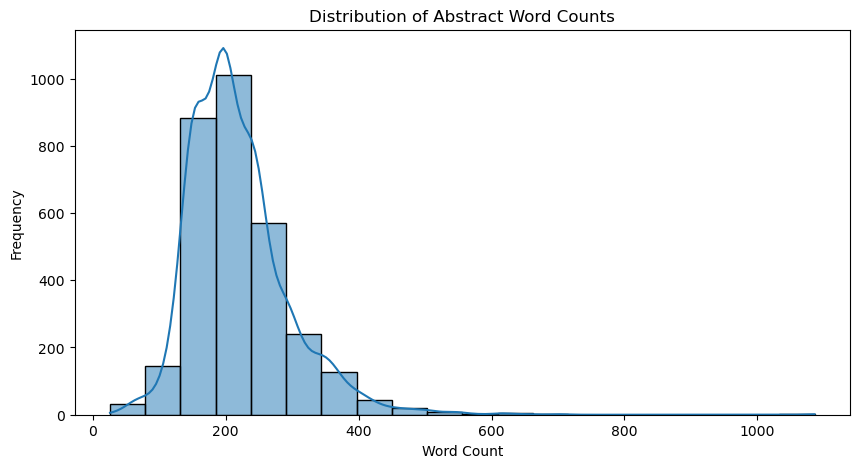

count    3086.000000
mean      218.509397
std        75.628361
min        26.000000
25%       166.000000
50%       203.000000
75%       250.000000
max      1086.000000
Name: word_count, dtype: float64

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'date' column is parsed if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Require non-null abstracts
if "abstract" not in df.columns:
    raise ValueError("Expected an 'abstract' column in the data.")
df = df.dropna(subset=["abstract"]).copy()

# Word count
df["word_count"] = df["abstract"].astype(str).str.split().apply(len)

print(df.info())

# Histogram of abstract lengths
plt.figure(figsize=(10, 5))
sns.histplot(df["word_count"], kde=True, bins=20)
plt.title("Distribution of Abstract Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

df["word_count"].describe()

## 3. Embedding and Dimensionality Reduction

In [6]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# Sentence embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["abstract"].tolist(), show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
embedding_df = pd.DataFrame(embeddings)

# PCA to 2D for visualization
pca = PCA(n_components=2, random_state=42)
embedding_2d = pca.fit_transform(embeddings)
print("Embedding shape:", embedding_df.shape)

# Save to CSV if needed
embedding_df.to_csv("abstract_embeddings.csv", index=False)
print("Saved embeddings to abstract_embeddings.csv (working dir).")

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Embedding shape: (3086, 384)
Saved embeddings to abstract_embeddings.csv (working dir).


## 4. PCA Scatter (annotate first 20)

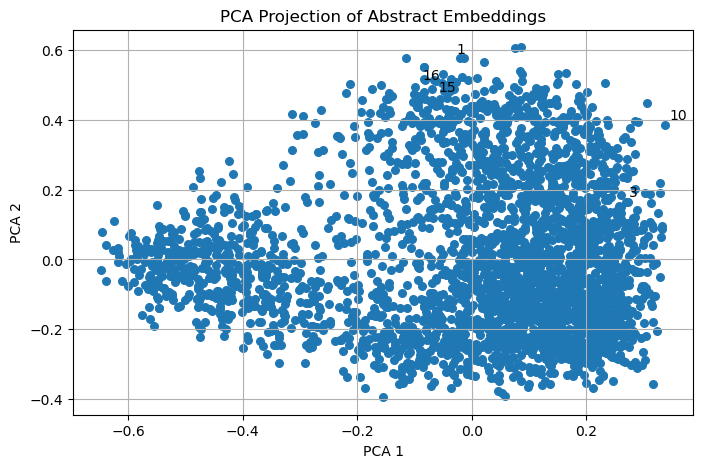

In [7]:
plt.figure(figsize=(8, 5))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=30)

# Annotate up to 20 points
titles = df["title"] if "title" in df.columns else pd.Series([f"Abstract {i+1}" for i in range(len(df))])
for i, title in enumerate(titles[:20]):
    plt.annotate(f"{i+1}", (embedding_2d[i, 0] + 0.5, embedding_2d[i, 1] + 0.5))

plt.title("PCA Projection of Abstract Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

## 5. Clustering and Topic Analysis

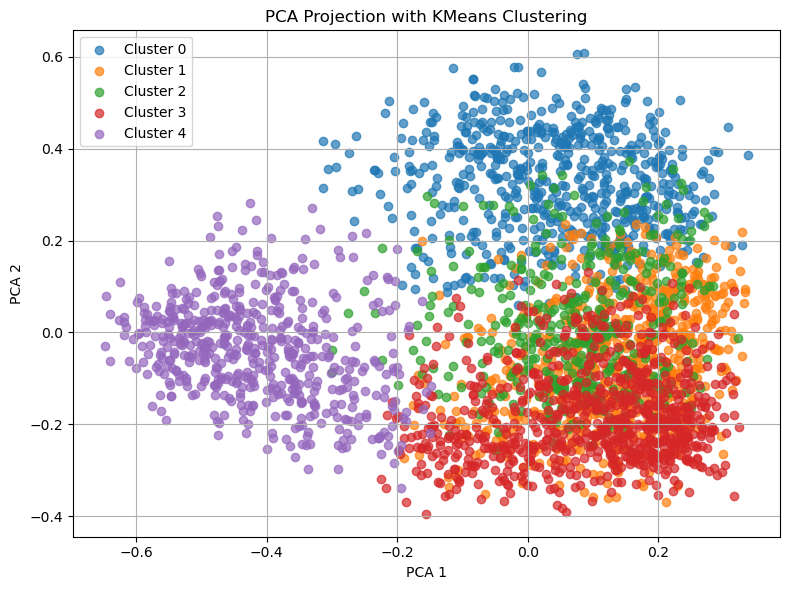


Cluster 0 — 623 abstracts:
 • Climate and predation drive variation of diel activity patterns in chacma baboons (Papio ursinus) across southern Africa
 • A k-mer-based maximum likelihood method for estimating distances of reads to genomes enables genome-wide phylogenetic placement.
 • Triggered and Spontaneous Dormancy in Bacteria During Feast-Famine Cycles with Stochastic Antibiotic Application
 • Factors affecting CRISPR-Cas defense against antibiotic resistance plasmids harbored by Enterococcus faecalis laboratory model strains and clinical isolates
 • Student-led experimental evolution reveals novel biofilm regulators of adaptation to multiple niches
 • Tiger diet in Ranthambore Tiger Reserve: how do metabarcoding and mechanical sorting compare?
 • Phylogenomic analysis of the collagen-like BclA proteins in Clostridioides difficile
 • Chromosomal-level genome of the Pinus massoniana 'Minlin WY36'
 • Is Aedes nr. albopictus synonymous with Aedes pseudalbopictus?
 • Whole-genome seq

In [8]:
from sklearn.cluster import KMeans

N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(embedding_df)

plt.figure(figsize=(8, 6))
for label in sorted(df["cluster"].unique()):
    pts = embedding_2d[df["cluster"] == label]
    plt.scatter(pts[:, 0], pts[:, 1], label=f"Cluster {label}", alpha=0.7)
plt.title("PCA Projection with KMeans Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show titles per cluster
if "title" in df.columns:
    for cluster_id in sorted(df["cluster"].unique()):
        titles = df.loc[df["cluster"] == cluster_id, "title"].tolist()
        print(f"\nCluster {cluster_id} — {len(titles)} abstracts:")
        for t in titles[:10]:
            print(" •", t)
        if len(titles) > 10:
            print(f"   … (+{len(titles)-10} more)")

## 6. Top TF‑IDF Keywords per Cluster

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

for cluster_id in sorted(df["cluster"].unique()):
    abstracts = df.loc[df["cluster"] == cluster_id, "abstract"].astype(str).tolist()
    if not abstracts:
        continue
    vectorizer = TfidfVectorizer(stop_words="english", max_features=10)
    X = vectorizer.fit_transform(abstracts)
    top_keywords = vectorizer.get_feature_names_out()
    print(f"\nCluster {cluster_id} Top Keywords: {', '.join(top_keywords)}")


Cluster 0 Top Keywords: analysis, data, gene, genes, genetic, genome, high, species, study, using

Cluster 1 Top Keywords: activity, binding, cell, cells, dna, membrane, protein, proteins, study, using

Cluster 2 Top Keywords: analysis, based, cell, data, gene, learning, model, models, protein, using

Cluster 3 Top Keywords: associated, cell, cells, disease, expression, gene, human, immune, mice, specific

Cluster 4 Top Keywords: activity, brain, findings, learning, memory, model, neural, neurons, using, visual


## 7. Word Clouds per Cluster

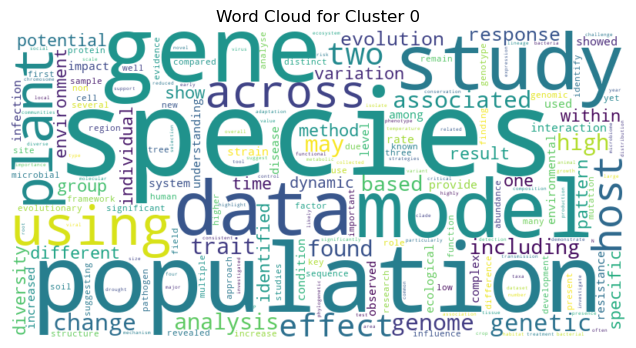

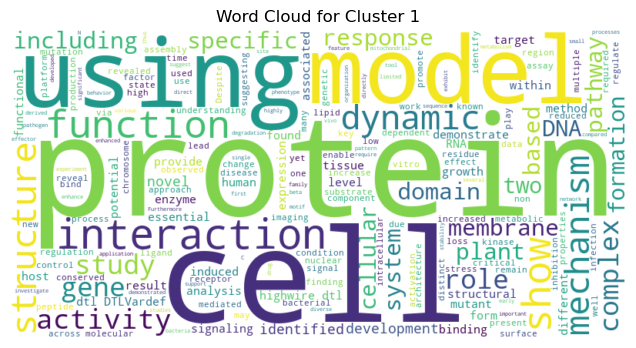

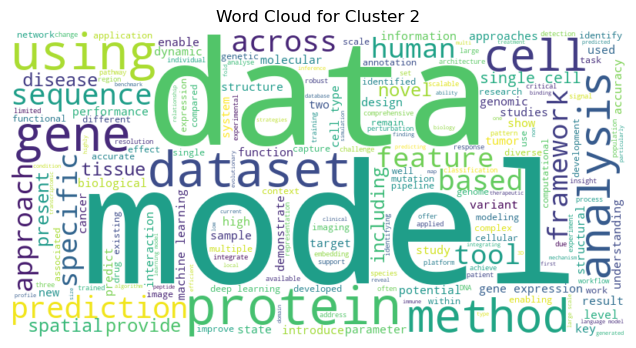

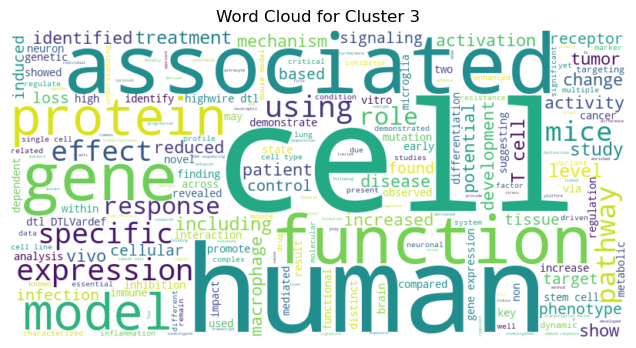

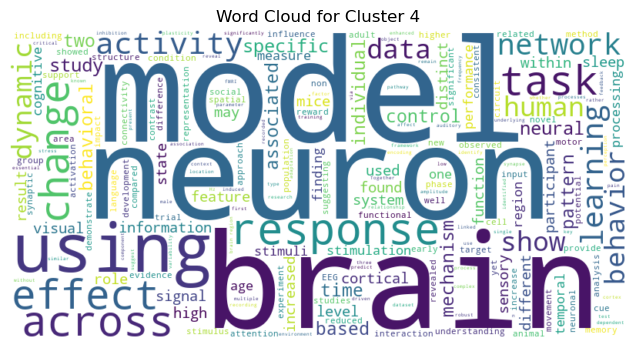

In [10]:
from wordcloud import WordCloud

for cluster_id in sorted(df["cluster"].unique()):
    abstracts = df.loc[df["cluster"] == cluster_id, "abstract"].astype(str)
    if abstracts.empty:
        continue
    text = abstracts.str.cat(sep=" ")
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()

## 8. In‑cluster Semantic Search (interactive)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display

q_box = widgets.Text(value='protein structure embeddings', description='Query', layout=widgets.Layout(width='60%'))
cluster_box = widgets.Text(value='', description='Cluster (opt)')
topk_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='TopK')
btn_search = widgets.Button(description='Search')
out_search = widgets.Output()

def run_search(_):
    with out_search:
        out_search.clear_output(wait=True)
        q = q_box.value.strip()
        if not q:
            print("Enter a query string.")
            return
        qv = model.encode([q], normalize_embeddings=True, convert_to_numpy=True)
        S = cosine_similarity(qv, embedding_df)[0]
        mask = np.ones(len(df), dtype=bool)
        if cluster_box.value.strip():
            try:
                cval = int(cluster_box.value.strip())
                if 'cluster' in df.columns:
                    mask = (df['cluster'] == cval).values
            except Exception:
                print("Cluster filter ignored (not an int or not available). Run clustering first if needed.")
        idx = np.argsort(S * mask)[::-1][:topk_slider.value]
        for i in idx:
            date_str = ""
            if "date" in df.columns and pd.notnull(df.loc[i, "date"]):
                date_str = str(df.loc[i, "date"].date())
            title = df.loc[i, "title"] if "title" in df.columns else f"Abstract {i+1}"
            print(f"[{S[i]:.3f}] {title} — {date_str}")

btn_search.on_click(run_search)
display(widgets.HBox([q_box, cluster_box, topk_slider]), btn_search, out_search)

Button(description='Search', style=ButtonStyle())

Output()